# Setup

In [2]:
import ugradio
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import lstsq, inv, norm
from scipy.fft import fft, ifft, fftfreq, fftshift, ifftshift
from scipy.stats import norm, linregress
from scipy.optimize import curve_fit, least_squares
from scipy.signal import find_peaks, stft
from scipy.special import j1
from uncertainties import ufloat
from dataclasses import dataclass
from typing import Dict, Optional, Tuple
import os
from astropy.time import Time
from astropy.coordinates import EarthLocation
import astropy.units as u
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable

No module named 'rtlsdr'


In [3]:
# Consistent Plot Params
titleSize = 15
axisSize = 15
legendSize = 13
graphSizeSingle = (8, 6)
graphSizeDouble = (15, 6)
graphSizeHorizontal = (20, 6)

# Data Extraction & Cleansing

In [4]:
@dataclass
class PointData:
    id: int
    l: float
    b: float
    ra: float
    dec: float
    LSB: Optional[np.ndarray] = None
    USB: Optional[np.ndarray] = None
    is_calibration: bool = False
    timestamp: str = ""

@dataclass
class Gaussian:
    amplitude: float
    mean: float
    stddev: float
    amplitude_err: float = -1.0
    mean_err: float = -1.0
    stddev_err: float = -1.0
    reduced_chi2: float = -1.0
    residuals: Optional[np.ndarray] = None

@dataclass
class FitPoint:
    l: float
    b: float
    gaussian1: Optional[Gaussian] = None
    gaussian2: Optional[Gaussian] = None
    gaussian3: Optional[Gaussian] = None

@dataclass
class MapData:
    l: float
    b: float
    total_mass: float = 0.0
    col_density: float = 0.0
    density: float = 0.0
    brightness: float = 0.0
    v1: Optional[float] = None
    v2: Optional[float] = None
    v3: Optional[float] = None
    a1: Optional[float] = None
    a2: Optional[float] = None
    a3: Optional[float] = None
    s1: Optional[float] = None
    s2: Optional[float] = None
    s3: Optional[float] = None
    m1: Optional[float] = None
    m2: Optional[float] = None
    m3: Optional[float] = None
    v_avg: Optional[float] = None

@dataclass
class MapPoint:
    l: float
    b: float
    v_avg: float
    brightness: float
    mass: float

In [5]:
def extractSdrPoints(base_path, normalize=False, correction="") -> Dict[int, Dict[int, PointData]]:
    # Dictionary of two SDRs (device_index 0 & 1)
    data = {
        0: {"normal": [], "calibration": []},
        1: {"normal": [], "calibration": []}
    }

    prefix = "ugastro\\Lab4Data\\"
    for sdr_index in [0, 1]:
        pol_folder = os.path.join(prefix+base_path, f"pol{sdr_index}")
        if not os.path.isdir(pol_folder):
            print(f"Warning: Folder {pol_folder} not found.")
            continue

        for fname in os.listdir(pol_folder):
            if fname.endswith(".npz") and fname.startswith("obs_"):
                # Parse the filename: obs_{point_id}_{mode}.npz
                parts = fname.replace(correction+".npz", "").split("_")
                try:
                    point_id = int(parts[1])
                    mode = "_".join(parts[2:])  # "LSB" or "USB"
                except (IndexError, ValueError):
                    print(f"Skipping unrecognized file: {fname}")
                    continue

                file_path = os.path.join(pol_folder, fname)
                try:
                    with np.load(file_path) as npzfile:    
                        spectrum = npzfile['spectrum']
                        if normalize:
                            spectrum = spectrum / np.max(spectrum)

                        point = PointData(
                            id=point_id,
                            l=npzfile["gal_l"].item(),
                            b=npzfile["gal_b"].item(),
                            ra=npzfile["ra"].item(),
                            dec=npzfile["dec"].item(),
                            is_calibration=bool(npzfile["is_calibration"].item()),
                            timestamp=str(npzfile["timestamp"])
                        )

                        if mode == "LSB":
                            point.LSB = spectrum
                            point.USB = None
                            point.is_calibration = False
                        elif mode == "USB":
                            point.USB = spectrum
                            point.LSB = None
                            point.is_calibration = False
                        elif mode == "cal_on":
                            point.USB = spectrum
                            point.is_calibration = True
                        else:
                            print(f"Unknown mode: {mode} in file {fname}")

                        if mode not in ("USB", "LSB"):
                            data[sdr_index]["calibration"].append(point)
                        else:
                            data[sdr_index]["normal"].append(point)
                            
                except Exception as e:
                    print(f"{file_path} Error: {e}")
                    continue
    return data

def merge_sdr_data(data_1, data_2):
    merged = {
        0: {"normal": [], "calibration": []},
        1: {"normal": [], "calibration": []}
    }

    for sdr_index in [0, 1]:
        for category in ["normal", "calibration"]:
            merged[sdr_index][category] = data_1[sdr_index][category] + data_2[sdr_index][category]

    return merged

def merge_sdrs_data(data_list):
    merged = {
        0: {"normal": [], "calibration": []},
        1: {"normal": [], "calibration": []}
    }

    for sdr_index in [0, 1]:
        for category in ["normal", "calibration"]:
            for data in data_list:
                merged[sdr_index][category].extend(data[sdr_index][category])

    return merged

In [6]:
#folder_path = "4_25_1"
#correction = ".npy"
#data_4_25 = extractSdrPoints(folder_path, normalize=True, correction=correction)

#folder_path = "4_28_1"
#data_4_28 = extractSdrPoints(folder_path, normalize=True)

folder_path = "4_29_CalInt_4"
data_1 = extractSdrPoints(folder_path, normalize=True)

folder_path = "4_29_CalInt_4_Missing"
data_2 = extractSdrPoints(folder_path, normalize=True)

folder_path = "4_29_CalInt_4_Missing_2"
data_3 = extractSdrPoints(folder_path, normalize=True)

folder_path = "4_29_CalInt_4_Missing_3"
data_4 = extractSdrPoints(folder_path, normalize=True)

data = merge_sdrs_data([data_1, data_2, data_3, data_4])

In [7]:
print(len(data[0]['normal']) // 2)
print(len(data[0]["calibration"]))

print(data[0]['normal'][0].LSB.shape)
print(data[0]['normal'][0].LSB.shape)

428
103
(2048,)
(2048,)


In [ ]:
LO_USB = 1420e6
LO_LSB = 1420.81150357e6
LINE_FREQ = 1420.405752e6
B = 12e6
SAMPLE_RATE = 2.2e6
WINDOW = 2048
bounds = (5, -5)
c = 299792458

In [ ]:
expected_points = []
for b in np.arange(15, 52, 2):
    delta_l = 2 / np.cos(np.radians(b))
    for l in np.arange(105, 162, delta_l):
        expected_points.append((l, b))

print(len(expected_points))


454


# Power Spectrum Plotting

In [9]:
def plot_power_spectra(points, which="USB", LO=LO_USB, spike_mask_range=None, normalize=False, xlim=None, ylim=None, title_extra=""):
    plt.figure(figsize=graphSizeSingle)

    freqs = fftfreq(WINDOW, 1/SAMPLE_RATE) + LO
    freqs = fftshift((freqs))[bounds[0]:bounds[1]]
    
    for point in points:
        spectrum = getattr(point, which)
        if spectrum is None:
            continue    # Skip

        spectrum = spectrum - np.mean(spectrum) if normalize else spectrum
        spectrum = fftshift(spectrum[bounds[0]:bounds[1]])
        if spike_mask_range:
            spectrum = mask_and_resample_spike(freqs, spectrum, spike_mask_range)

        label = f"ID {point.id} (l={point.l:.1f}, b={point.b:.1f})"
        plt.plot(freqs / 1e9, spectrum / 4e3, label=label, alpha=0.7)

    plt.xlabel("RF Frequency (GHz)", fontsize=axisSize)
    plt.ylabel("Power Spectrum (Arbitary Log Scale)", fontsize=axisSize)
    #plt.yscale("log")
    plt.xlim(xlim)
    plt.ylim(ylim)
    #plt.legend(fontsize=legendSize)
    #plt.legend()
    title_label = "(Normalized)" if normalize else "(Uncalibrated)"
    plt.title(f"{which} Power Spectra vs RF {title_label}", size=titleSize)
    plt.grid()
    plt.show()

def mask_and_resample_spike(freqs, spectrum, spike_range):
    low, high = spike_range
    center_freq = (low + high) / 2
    
    mask_left = (freqs >= low) & (freqs < center_freq)
    mask_right = (freqs >= center_freq) & (freqs <= high)

    # Find nearest neighbors outside the mask
    idx_left = np.where(freqs < low)[0]
    idx_right = np.where(freqs > high)[0]

    if len(idx_left) > 0:
        val_left = spectrum[idx_left[-1]]  # last good point before spike
    else:
        val_left = spectrum[0]

    if len(idx_right) > 0:
        val_right = spectrum[idx_right[0]]  # first good point after spike
    else:
        val_right = spectrum[-1]

    cleaned = np.copy(spectrum)
    cleaned[mask_left] = val_left
    cleaned[mask_right] = val_right

    return cleaned


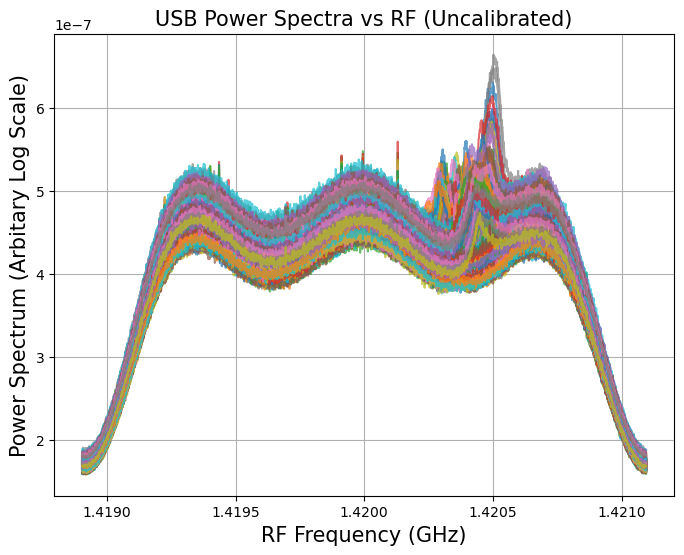

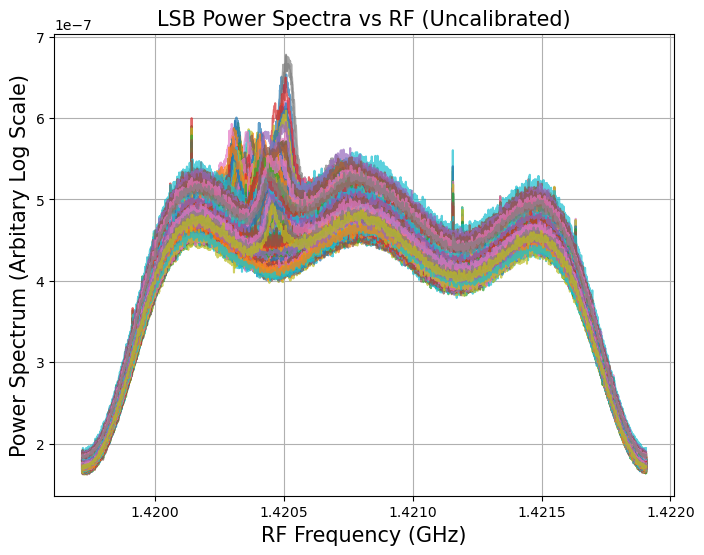

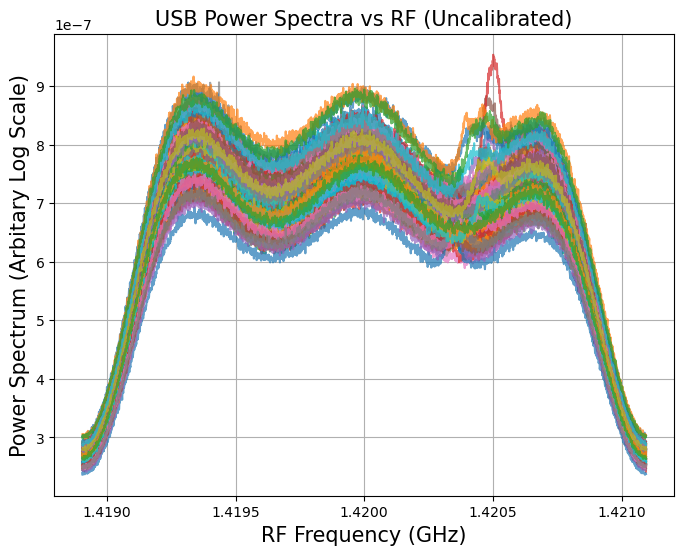

In [10]:
mask = (1.419995e9, 1.420005e9)
plot_power_spectra(data[0]["normal"], which="USB", LO=LO_USB)
plot_power_spectra(data[0]["normal"], which="LSB", LO=LO_LSB, spike_mask_range=mask)
plot_power_spectra(data[0]["calibration"], which="USB", LO=LO_USB)

# Line Shape, Gain, Calibration

In [11]:
lat, lon = ugradio.leo.lat, ugradio.leo.lon
alt = ugradio.leo.alt

def timestampToJD(timestamp):
    t = Time(timestamp, format='isot', scale='utc')  # ISO-8601 format with UTC
    return t.jd

def onlineOfflineSpectra(points, normalize=False, spike_range=None) -> Dict[Tuple[float, float], Dict[str, np.ndarray]]:
    temp_storage: Dict[Tuple[float, float], Dict[str, np.ndarray]] = {}
    freqs = fftfreq(WINDOW, 1/SAMPLE_RATE) + LO_LSB
    freqs_lsb = fftshift((freqs))

    for point in points:
        key = (round(point.l, 3), round(point.b, 3))
        if key not in temp_storage:
            temp_storage[key] = {"USB": None, "LSB": None, "ra": None, "dec": None, "timestamp": None}

        if point.USB is not None:
            temp_storage[key]["USB"] = point.USB
        if point.LSB is not None:
            temp_storage[key]["LSB"] = point.LSB

        temp_storage[key]["ra"] = point.ra
        temp_storage[key]["dec"] = point.dec
        temp_storage[key]["timestamp"] = point.timestamp

    result: Dict[Tuple[float, float], Dict[str, np.ndarray]] = {}

    for (l, b), spectra in temp_storage.items():
        usb = spectra["USB"]
        lsb = spectra["LSB"]
        ra = spectra["ra"]
        dec = spectra["dec"]
        timestamp = spectra["timestamp"]

        if usb is None or lsb is None:
            # skip incomplete points
            continue

        if normalize:
            usb = usb / np.max(usb)
            lsb = lsb / np.max(lsb)

        if spike_range:
            lsb = mask_and_resample_spike(freqs_lsb, lsb, spike_range)

        mid = len(usb) // 2
        online, offline = np.zeros(len(usb)), np.zeros(len(usb))
        online[mid:], offline[mid:] = lsb[mid:], usb[mid:]
        online[:mid], offline[:mid] = usb[:mid], lsb[:mid]

        line_shape = online / offline
        #line_shape = line_shape - np.mean(line_shape)  
        jd = timestampToJD(timestamp)

        result[(l, b)] = {
            "online": online,
            "offline": offline,
            "line_shape": line_shape,
            "ra": ra,
            "dec": dec,
            "jd": jd
        }

    return result

def plot_lineshapes(online_offline_data, corrected=False, xlim=None, ylim=None, title_extra=""):
    plt.figure(figsize=graphSizeSingle)
    freqs = fftfreq(WINDOW, 1/SAMPLE_RATE) + LO_USB
    freqs = fftshift(freqs)[bounds[0]:bounds[1]]
    mid = len(freqs) // 2
    v = np.zeros(len(freqs) - mid)
    v = -c * ((freqs[mid:] - LINE_FREQ) / LINE_FREQ)
    #v = np.zeros(len(freqs))
    #v = -c * ((freqs - LINE_FREQ) / LINE_FREQ)
    v_corrections = []

    for (l, b), spectra in online_offline_data.items():
        lineshape = spectra["line_shape"]
        lineshape = fftshift(lineshape[bounds[0]:bounds[1]])[mid:]
        #lineshape = fftshift(lineshape[bounds[0]:bounds[1]])

        baseline_mask = (v < 0) | (v > 25000)
        poly_coeffs = np.polyfit(v[baseline_mask], lineshape[baseline_mask], deg=1)
        baseline_fit = np.polyval(poly_coeffs, v)
        lineshape = (lineshape - baseline_fit)

        label = f"(l={l:.1f}, b={b:.1f})"

        if corrected:
            ra = spectra["ra"]
            dec = spectra["dec"]
            jd = spectra["jd"]
            v_projected = ugradio.doppler.get_projected_velocity(ra, dec, jd, lat, lon, alt)
            v_corrected = v - v_projected
            v_corrections.append((v, v_projected, v_corrected))

            plt.plot(v_corrected / 1e3, lineshape, alpha=0.7, label=label)

        else:
            plt.plot(v / 1e3, lineshape, alpha=0.7, label=label)

    plt.xlabel("Observed Doppler Velocity (km/s)", fontsize=axisSize)
    plt.ylabel("Line Shape (Online Data / Offline Data)", fontsize=axisSize)
    plt.title(f"Overlayed Line Shapes {title_extra}", size=titleSize)
    plt.grid()
    plt.xlim(xlim)
    plt.ylim(ylim)
    #plt.legend(fontsize=legendSize, ncol=2)  # 2 columns for compactness
    plt.show()

    return v_corrections

In [12]:
def calculate_tsys(power_spectrum):
    # Symmetrize the power spectrum to force cosine iFFT
    n = len(power_spectrum)
    sym_power = np.concatenate((power_spectrum, power_spectrum[::-1]))
    
    # Inverse FFT
    autocorr = np.fft.ifft(sym_power).real
    
    # T_sys is the first lag of autocorrelation
    T_sys = autocorr[0]
    return T_sys

def find_gain_per_point_from_data(observation_data, calibration_data, Tsys_increment=79.0):
    N_obs = len(observation_data)
    gains = []

    cal_coords = np.array([[p.l, p.b] for p in calibration_data])
    cal_spectra = np.array([p.USB for p in calibration_data])

    for i, obs in enumerate(observation_data):
        if obs.USB is None:
            continue
        l_obs, b_obs = obs.l, obs.b
        s_cold = obs.USB

        # Find closest calibration point
        deltas = cal_coords - np.array([l_obs, b_obs])
        distances = np.sqrt((deltas[:,0]*np.cos(np.radians(b_obs)))**2 + (deltas[:,1])**2)
        nearest_idx = np.argmin(distances)
        s_cal = cal_spectra[nearest_idx]

        #Tsys_cold = np.fft.ifft(s_cold)
        #Tsys_cal = Tsys_cold + Tsys_increment

        bottom_sum = np.sum(s_cal - s_cold)
        
        l = round(l_obs, 3)
        b = round(b_obs, 3)

        try:
            G = (Tsys_increment * np.sum(s_cold)) / bottom_sum
        except Exception as e:
            print("Denominator = 0")
            G = 0
        gains.append((l, b, G))

    return gains 

In [13]:
def apply_gain_to_line_shapes(gains_list, online_offline_data):
    calibrated_data: Dict[Tuple[float, float], Dict[str, np.ndarray]] = {}

    gain_dict = {(l, b): gain for (l, b, gain) in gains_list}

    for coord, point in online_offline_data.items():
        if coord in gain_dict:
            if coord not in calibrated_data:
                calibrated_data[coord] = {"line": None, "ra": None, "dec": None, "jd": None}

            gain = gain_dict[coord]
            calibrated_line_shape = point["line_shape"] * gain

            calibrated_data[coord]["line"] = calibrated_line_shape
            calibrated_data[coord]["ra"] = point["ra"]
            calibrated_data[coord]["dec"] = point["dec"]
            calibrated_data[coord]["jd"] = point["jd"]
        else:
            print(f"Warning: No gain found for coordinate {coord}. Skipping.")
    
    return calibrated_data

Max Gain [SDR0]: 239.3404597132521 at (l, b) = (128.565, 21)
Min Gain [SDR0]: 119.91798314356853 at (l, b) = (132.188, 17)
Max Gain [SDR1]: 126.77027287652041 at (l, b) = (120.209, 23)
Min Gain [SDR1]: 28.04705343303723 at (l, b) = (111.62, 25)
Fit failed for (l, b) = (105.0, 31)
Fit failed for (l, b) = (107.442, 35)
Fit failed for (l, b) = (115.017, 37)
Fit failed for (l, b) = (112.95, 41)
Fit failed for (l, b) = (126.877, 43)
Fit failed for (l, b) = (119.142, 45)
Fit failed for (l, b) = (110.865, 47)
Fit failed for (l, b) = (138.534, 49)
Fit failed for (l, b) = (146.314, 51)
Fit failed for (l, b) = (154.853, 47)
Fit failed for (l, b) = (114.146, 49)
Fit failed for (l, b) = (119.663, 47)
Fit failed for (l, b) = (125.528, 47)
Fit failed for (l, b) = (130.424, 51)
Fit failed for (l, b) = (136.78, 51)


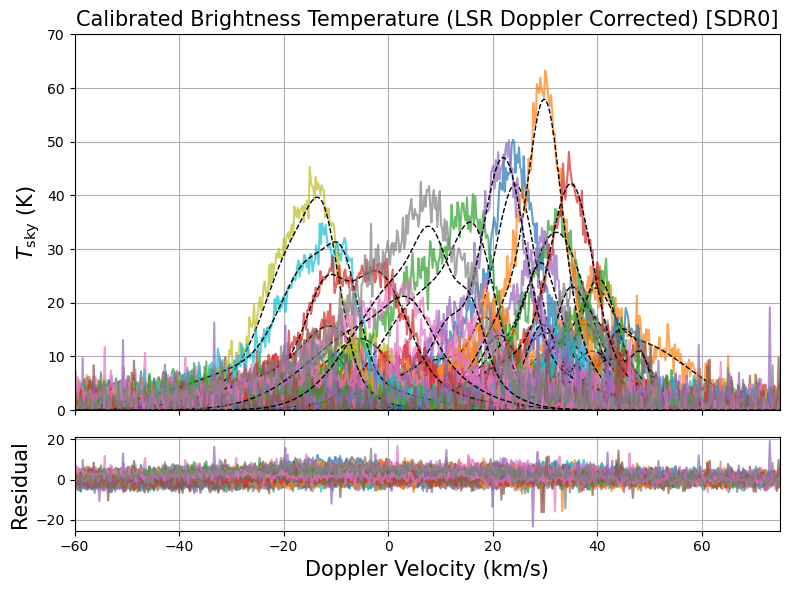

Failed Points = 15
15


In [63]:
counter = 0

def gaussian(x, amp, mean, sigma):
    return amp * np.exp(-0.5 * ((x - mean) / sigma) ** 2)

def model_sum(x, *params):
    n = len(params) // 3
    return sum(gaussian(x, *params[i*3:i*3+3]) for i in range(n))

def generate_initial_guesses(x_data, y_data, max_gaussians=3):
    peaks, properties = find_peaks(y_data, height=np.max(y_data) * 0.1, distance=5)
    peak_heights = properties["peak_heights"]
    
    sorted_indices = np.argsort(peak_heights)[::-1]
    selected_peaks = peaks[sorted_indices[:max_gaussians]]

    guesses = []
    for peak in selected_peaks:
        amp = y_data[peak]
        mean = x_data[peak]
        sigma = 5e3  
        guesses.extend([amp, mean, sigma])
    
    return guesses

def fit_gaussians(v, y, peak_mask, init_g=None, amp=3, num_attempts=10000):
    best_chi2 = np.inf
    best_params = None
    best_pcov = None
    best_n = 0
    best_resid = None

    x_data = v[peak_mask]
    y_data = y[peak_mask]

    for n_gauss in range(1, 5):
        init_guess = generate_initial_guesses(x_data, y_data, max_gaussians=n_gauss)

        bounds_lower = [0, np.min(x_data), 1e3] * n_gauss
        bounds_upper = [np.max(y_data)*2, np.max(x_data), 1e5] * n_gauss

        try:
            popt, pcov = curve_fit(
                model_sum, x_data, y_data, 
                p0=init_guess, 
                bounds=(bounds_lower, bounds_upper),
                maxfev=num_attempts
            )

            means = [popt[i*3+1] for i in range(n_gauss)]
            # Reject if any means are too close (less than 3 km/s separation)
            if any(abs(m1 - m2) < 1e3 for i, m1 in enumerate(means) for m2 in means[i+1:]):
                continue

            fit_curve = model_sum(x_data, *popt)
            residuals = y_data - fit_curve
            dof = len(x_data) - len(popt)
            chi2 = np.sum(residuals**2) / dof if dof > 0 else np.inf

            if chi2 < best_chi2:
                best_chi2 = chi2
                best_params = popt
                best_pcov = pcov
                best_n = n_gauss
                best_resid = residuals

        except Exception as e:
            print(f"Fit with {n_gauss} Gaussians failed: {e}")

            continue

    gaussians = []
    if best_params is not None and best_pcov is not None:
        for i in range(best_n):
            amp_, mean, sigma = best_params[i*3:i*3+3]
            
            if sigma > 70e3 or amp_ < amp:
                continue

            amp_err, mean_err, sigma_err = np.sqrt(np.diag(best_pcov))[i*3:i*3+3]
            gaussians.append(Gaussian(
                amplitude=amp_,
                mean=mean,
                stddev=sigma,
                amplitude_err=amp_err,
                mean_err=mean_err,
                stddev_err=sigma_err,
                reduced_chi2=best_chi2,
                residuals=best_resid
            ))
    else:
        print(f"Failed to build Gaussians")
        gaussians = []

    gaussians = sorted(gaussians, key=lambda g: g.amplitude, reverse=True)[:3]

    return gaussians, best_chi2, best_n, best_resid

def plot_calibrated_tsky_fits(data_dict, points_to_plot, xlim=None, ylim=None, init_g=None, amp=3, title_extra=""):
    counter = 0
    fig, (ax_main, ax_resid) = plt.subplots(
        2, 1, figsize=graphSizeSingle, sharex=True, gridspec_kw={'height_ratios': [4, 1]}
    )

    freqs = fftfreq(WINDOW, 1/SAMPLE_RATE) + LO_USB
    freqs = fftshift(freqs)[bounds[0]:bounds[1]]
    mid = len(freqs) // 2
    v_base = np.zeros(len(freqs) - mid)
    v_base = -c * ((freqs[mid:] - LINE_FREQ) / LINE_FREQ)

    fit_points, failed_points = [], []

    for l_b in points_to_plot:
        if l_b not in data_dict:
            print(f"Warning: (l, b) = {l_b} not found in data.")
            continue
        
        label = f"(l={l_b[0]:.1f}, b={l_b[1]:.1f})"
        lineshape = data_dict[l_b]["line"]
        spectrum = fftshift(lineshape)[bounds[0]:bounds[1]][mid:]
        ra = data_dict[l_b]["ra"]
        dec = data_dict[l_b]["dec"]
        jd = data_dict[l_b]["jd"]
        v_projected = ugradio.doppler.get_projected_velocity(ra, dec, jd, lat, lon, alt)
        v = v_base - v_projected

        peak_mask = (v > -60e3) & (v < 70e3)
        
        if np.any(peak_mask) == False:
            print(f"Skipping (l, b) = {l_b} due to empty peak_mask")
            failed_points.append((l, b))
            continue

        baseline_mask = (v < -80e3) | (v > 70e3)
        poly_coeffs = np.polyfit(v[baseline_mask], spectrum[baseline_mask], deg=1)
        baseline_fit = np.polyval(poly_coeffs, v)
        y_corrected = spectrum - baseline_fit

        ax_main.plot(v / 1e3, y_corrected, label=label, alpha=0.7)

        init_guess = [50.0, 25, 15e3] if init_g is None else init_g
        gaussians, chi2, n_gauss, residuals = fit_gaussians(v, y_corrected, peak_mask, init_g=init_guess, amp=amp, num_attempts=30000)

        total_fit = np.zeros_like(v)
        for i, g in enumerate(gaussians):
            fit_curve = gaussian(v, g.amplitude, g.mean, g.stddev)
            total_fit += fit_curve

        ax_main.plot(v / 1e3, total_fit, color="black", linestyle="--", linewidth=1, label=f"Model Sum {label}")

        residuals = y_corrected - total_fit
        ax_resid.plot(v / 1e3, residuals, alpha=0.7)

        if len(gaussians) == 0:
            counter += 1
            print(f"Fit failed for (l, b) = {l_b}")
            failed_points.append(l_b)

        fit_point = FitPoint(
            l=l_b[0], b=l_b[1],
            gaussian1=gaussians[0] if len(gaussians) > 0 else None,
            gaussian2=gaussians[1] if len(gaussians) > 1 else None,
            gaussian3=gaussians[2] if len(gaussians) > 2 else None,
        )
        fit_points.append(fit_point)

    ax_main.set_ylabel(r"$T_{\rm sky}$ (K)", fontsize=axisSize)
    ax_main.set_title(f"Calibrated Brightness Temperature {title_extra}", fontsize=titleSize)
    ax_main.grid()
    ax_main.set_xlim(xlim)
    ax_main.set_ylim(ylim)

    ax_resid.set_xlabel("Doppler Velocity (km/s)", fontsize=axisSize)
    ax_resid.set_ylabel("Residual", fontsize=axisSize)
    ax_resid.grid()

    plt.tight_layout()
    plt.show()

    print(f"Failed Points = {counter}")

    return fit_points, failed_points


online_offline_data_sdr0 = onlineOfflineSpectra(data[0]["normal"], spike_range=(1.419995e9, 1.420005e9))
online_offline_data_sdr1 = onlineOfflineSpectra(data[1]["normal"], spike_range=(1.419995e9, 1.420005e9))


gains_sdr0 = find_gain_per_point_from_data(data[0]["normal"], data[0]["calibration"])   
gains_sdr1 = find_gain_per_point_from_data(data[1]["normal"], data[1]["calibration"])   

max_g, min_g = max(gains_sdr0, key=lambda x: x[2]), min(gains_sdr0, key=lambda x: x[2])
print(f"Max Gain [SDR0]: {max_g[2]} at (l, b) = ({max_g[0]}, {max_g[1]})")
print(f"Min Gain [SDR0]: {min_g[2]} at (l, b) = ({min_g[0]}, {min_g[1]})")

max_g, min_g = max(gains_sdr1, key=lambda x: x[2]), min(gains_sdr1, key=lambda x: x[2])
print(f"Max Gain [SDR1]: {max_g[2]} at (l, b) = ({max_g[0]}, {max_g[1]})")
print(f"Min Gain [SDR1]: {min_g[2]} at (l, b) = ({min_g[0]}, {min_g[1]})")


T_sky_sdr0 = apply_gain_to_line_shapes(gains_sdr0, online_offline_data_sdr0)
T_sky_sdr1 = apply_gain_to_line_shapes(gains_sdr1, online_offline_data_sdr1)

points = [
    (133.617, 33),
    (112.513, 37),
    (110.147, 39),
    (112.721, 39),
    (105.0, 41),
    (110.3, 41),
    (112.95, 41),
    (107.735, 43),
    (110.469, 43),
    (113.204, 43)
]


points = [l_b for l_b in T_sky_sdr0.keys()]
points = [points[i] for i in range(0, len(points), 9)]

fit_points_sdr0, failed_points_0 = plot_calibrated_tsky_fits(T_sky_sdr0, points, init_g=[50.0, 25, 15e3], amp=5, title_extra="(LSR Doppler Corrected) [SDR0]", xlim=(-60, 75), ylim=(0, 70))
#fit_points_sdr1, failed_points_1 = plot_calibrated_tsky_fits(T_sky_sdr1, points, init_g=[20.0, 25, 15e3], amp=2.5, title_extra="(LSR Doppler Corrected) [SDR1]", xlim=(-60, 75), ylim=(0, 28))

print(len(failed_points_0))
#print(len(fit_points_sdr0))
#print(len(fit_points_sdr1))

#_, failed_points_2 = plot_calibrated_tsky_fits(T_sky_sdr0, failed_points, init_g=[50.0, 25, 15e3], amp=7, title_extra="(LSR Doppler Corrected) [SDR0]", xlim=(-60, 75), ylim=(0, 70))

In [66]:
@dataclass
class Gaussian:
    amplitude: float
    mean: float
    stddev: float
    amplitude_err: float = -1.0
    mean_err: float = -1.0
    stddev_err: float = -1.0
    reduced_chi2: float = -1.0
    residuals: Optional[np.ndarray] = None

@dataclass
class FitPoint:
    l: float
    b: float
    gaussian1: Optional[Gaussian] = None
    gaussian2: Optional[Gaussian] = None
    gaussian3: Optional[Gaussian] = None

print(len(fit_points_sdr0))
print(len(fit_points_sdr1))

amp_err_0, mean_err_0, stddev_err_0, chi2_0 = [], [], [], []

counter0 = 0
for p in fit_points_sdr0:
    if p.gaussian1:
        counter0 += 1
    for g in [p.gaussian1, p.gaussian2, p.gaussian3]:
        if not g:
            continue
        #print(g)
        amp_err_0.append(g.amplitude_err)
        mean_err_0.append(g.mean_err)
        stddev_err_0.append(g.stddev_err)
        chi2_0.append(g.reduced_chi2)

amp_err_1, mean_err_1, stddev_err_1, chi2_1 = [], [], [], []

counter1 = 0
for p in fit_points_sdr1:
    if p.gaussian1:
        counter1 += 1
    for g in [p.gaussian1, p.gaussian2, p.gaussian3]:
        if not g:
            continue
        #print(g)
        if g.reduced_chi2 > 1.1 and g.mean_err < 20000:
            amp_err_1.append(g.amplitude_err)
            mean_err_1.append(g.mean_err)
            stddev_err_1.append(g.stddev_err)
            chi2_1.append(g.reduced_chi2)
        
print(f"Number of fit points = {counter0}")
print(f"[SDR0] Min / Max Amp Error = ({min(amp_err_0)}, {max(amp_err_0)})")
print(f"[SDR0] Avg Amp Error = {np.mean(amp_err_0)}")
print(f"[SDR0] Min / Max Mean Error = ({min(mean_err_0)}, {max(mean_err_0)})")
print(f"[SDR0] Avg Mean Error = {np.mean(mean_err_0)}")
print(f"[SDR0] Min / Max Sigma Error = ({min(stddev_err_0)}, {max(stddev_err_0)})")
print(f"[SDR0] Avg Sigma Error = {np.mean(stddev_err_0)}")
print(f"[SDR0] Min / Max Reduced Chi2 = ({min(chi2_0)}, {max(chi2_0)})")
print(f"[SDR0] Avg Reduced Chi2 = {np.mean(chi2_0)}")

print(f"Number of fit points = {counter1}")        
print(f"[SDR1] Min / Max Amp Error = ({min(amp_err_1)}, {max(amp_err_1)})")
print(f"[SDR1] Avg Amp Error = {np.mean(amp_err_1)}")
print(f"[SDR1] Min / Max Mean Error = ({min(mean_err_1)}, {max(mean_err_1)})")
print(f"[SDR1] Avg Mean Error = {np.mean(mean_err_1)}")
print(f"[SDR1] Min / Max Sigma Error = ({min(stddev_err_1)}, {max(stddev_err_1)})")
print(f"[SDR1] Avg Sigma Error = {np.mean(stddev_err_1)}")
print(f"[SDR1] Min / Max Reduced Chi2 = ({min(chi2_1)}, {max(chi2_1)})")
print(f"[SDR1] Avg Reduced Chi2 = {np.mean(chi2_1)}")

print(chi2_1)

48
86
Number of fit points = 33
[SDR0] Min / Max Amp Error = (0.25061292162443444, 4.156883503811333)
[SDR0] Avg Amp Error = 1.3640808282567767
[SDR0] Min / Max Mean Error = (73.98714597300213, 3061.1947017566645)
[SDR0] Avg Mean Error = 577.5464615683795
[SDR0] Min / Max Sigma Error = (104.30386289793064, 2153.3323405018564)
[SDR0] Avg Sigma Error = 556.250682282382
[SDR0] Min / Max Reduced Chi2 = (2.316273067850672, 6.783054369127328)
[SDR0] Avg Reduced Chi2 = 3.932948057966293
Number of fit points = 62
[SDR1] Min / Max Amp Error = (0.24234466133993396, 1.4005419965401589)
[SDR1] Avg Amp Error = 0.6124083938209831
[SDR1] Min / Max Mean Error = (139.21903402688525, 9015.186522203428)
[SDR1] Avg Mean Error = 1781.955486581988
[SDR1] Min / Max Sigma Error = (201.86103605129813, 5039.0678444148425)
[SDR1] Avg Sigma Error = 1181.7978170807255
[SDR1] Min / Max Reduced Chi2 = (1.9745911360998718, 1.9936109066036782)
[SDR1] Avg Reduced Chi2 = 1.9841010213517747
[1.9745911360998718, 1.9745911

In [46]:
def average_gaussians_diagnostics(fit_points_sdr0, fit_points_sdr1, threshold_kms=10):
    def get_gaussians(fp):
        return [g for g in [fp.gaussian1, fp.gaussian2, fp.gaussian3] if g is not None]

    def match_gaussians(g0_list, g1_list):
        matched = []
        used = set()
        for g0 in g0_list:
            best_match = None
            best_diff = float("inf")
            for idx, g1 in enumerate(g1_list):
                if idx in used:
                    continue
                diff = abs((g0.mean - g1.mean) / 1e3)  # km/s
                if diff < best_diff and diff <= threshold_kms:
                    best_match = idx
                    best_diff = diff
            if best_match is not None:
                g1 = g1_list[best_match]
                used.add(best_match)

                w0 = 1 / g0.mean_err**2 if g0.mean_err > 0 else 1
                w1 = 1 / g1.mean_err**2 if g1.mean_err > 0 else 1
                v_avg = (g0.mean * w0 + g1.mean * w1) / (w0 + w1)
                amp_avg = (g0.amplitude * w0 + g1.amplitude * w1) / (w0 + w1)
                sigma_avg = (g0.stddev * w0 + g1.stddev * w1) / (w0 + w1)
                matched.append((v_avg, amp_avg, sigma_avg))
        return matched

    dict0 = {(fp.l, fp.b): fp for fp in fit_points_sdr0}
    dict1 = {(fp.l, fp.b): fp for fp in fit_points_sdr1}
    keys0 = set(dict0.keys())
    keys1 = set(dict1.keys())
    common_keys = keys0 & keys1
    only_sdr0 = keys0 - keys1
    only_sdr1 = keys1 - keys0

    map_data_list = []
    fallback_points = []
    params = []

    for key in common_keys:
        fp0 = dict0[key]
        fp1 = dict1[key]
        g0s, g1s = get_gaussians(fp0), get_gaussians(fp1)

        matched = match_gaussians(g0s, g1s)
        if matched:
            matched.sort(key=lambda x: x[1], reverse=True)
            params = [[v, a, s] for v, a, s in matched[:3]]

        else:
            fallback_points.append(key)
            # Choose fallback from the SDR with greater total amplitude
            a0 = sum(g.amplitude for g in g0s) * 0.75
            a1 = sum(g.amplitude for g in g1s) * 0.75
            fallback_gaussians = g0s if a0 >= a1 else g1s
            fallback_gaussians = sorted(fallback_gaussians, key=lambda g: g.amplitude, reverse=True)
            v_list = [g.mean for g in fallback_gaussians[:3]]
            a_list = [g.amplitude * 0.75 for g in fallback_gaussians[:3]]
            s_list = [g.stddev for g in fallback_gaussians[:3]]
            for i in range(3):
                if len(v_list) > i:
                    params.append([v_list[i], a_list[i], s_list[i]])

        map_data = MapData(
            l=fp0.l,
            b=fp0.b,
            v1=params[0][0] if len(params) > 0 else None,
            v2=params[1][0] if len(params) > 1 else None,
            v3=params[2][0] if len(params) > 2 else None,
            a1=params[0][1] if len(params) > 0 else None,
            a2=params[1][1] if len(params) > 1 else None,
            a3=params[2][1] if len(params) > 2 else None,
            s1=params[0][2] if len(params) > 0 else None,
            s2=params[1][2] if len(params) > 1 else None,
            s3=params[2][2] if len(params) > 2 else None,
            v_avg=sum(p[0] for p in params) / len(params) if params else None,
        )
        map_data_list.append(map_data)

    diagnostics = {
        "total_sdr0": len(fit_points_sdr0),
        "total_sdr1": len(fit_points_sdr1),
        "only_in_sdr0": len(only_sdr0),
        "only_in_sdr1": len(only_sdr1),
        "shared_points": len(common_keys),
        "points_using_fallback": len(fallback_points),
        "successful_matches": len(map_data_list)
    }

    import pprint
    pprint.pprint(diagnostics)

    return map_data_list, fallback_points

map_data, fallback_points = average_gaussians_diagnostics(fit_points_sdr0, fit_points_sdr1, threshold_kms=30)
print(map_data)

{'only_in_sdr0': 0,
 'only_in_sdr1': 0,
 'points_using_fallback': 135,
 'shared_points': 428,
 'successful_matches': 428,
 'total_sdr0': 428,
 'total_sdr1': 428}
[MapData(l=138.67, b=27, total_mass=0.0, col_density=0.0, density=0.0, brightness=0.0, v1=18370.991216356288, v2=None, v3=None, a1=8.259477743232562, a2=None, a3=None, s1=10082.781603793308, s2=None, s3=None, m1=None, m2=None, m3=None, v_avg=18370.991216356288), MapData(l=114.766, b=35, total_mass=0.0, col_density=0.0, density=0.0, brightness=0.0, v1=18370.991216356288, v2=None, v3=None, a1=8.259477743232562, a2=None, a3=None, s1=10082.781603793308, s2=None, s3=None, m1=None, m2=None, m3=None, v_avg=18370.991216356288), MapData(l=109.883, b=35, total_mass=0.0, col_density=0.0, density=0.0, brightness=0.0, v1=18370.991216356288, v2=None, v3=None, a1=8.259477743232562, a2=None, a3=None, s1=10082.781603793308, s2=None, s3=None, m1=None, m2=None, m3=None, v_avg=18370.991216356288), MapData(l=105.0, b=45, total_mass=0.0, col_densit

In [ ]:
theta = 2 * (np.pi / 180)
solid_angle = theta**2
m_H = 1.67e-24
M_sun = 1.989e33

def estimate_distance_pc(b_deg):
    return 50 / np.sin(np.radians(np.abs(b_deg)))

def estimate_distance_cm(b_deg):
    scale = 3.086e18  # cm in a parsec
    return (50 / np.sin(np.radians(np.abs(b_deg)))) * scale

def linear_area(b):
    d = estimate_distance_cm(b)
    return (theta * d) ** 2

def compute_mass(mapData_list, solar_mass=True):
    factor = M_sun if solar_mass else 1.0
    coeff = 1.8e18 * m_H * solid_angle / factor
    print(coeff)

    for point in mapData_list:
        masses = []
        point.total_mass = 0.0

        for i in range(1, 4):
            amp = getattr(point, f'a{i}', None)
            sigma = getattr(point, f's{i}', None)
            if amp is not None and sigma is not None:
                d_cm = estimate_distance_cm(point.b)
                delta_v = sigma * 2
                variables = amp * (delta_v) * np.sqrt(2 * np.pi) * (d_cm / 100)**2
                #delta_v = sigma * 100
                #variables = amp * (delta_v) * np.sqrt(2 * np.pi) * (d_cm)**2
                mass = coeff * variables
                mass = mass
                masses.append(mass)
                point.total_mass += mass
                setattr(point, f'm{i}', mass)

                volume_cm3 = (1/3) * solid_angle * d_cm**3
                total_mass_g = point.total_mass * M_sun
                n_H = total_mass_g / (m_H * volume_cm3) if volume_cm3 > 0 else 0
                point.n_H = n_H

    return mapData_list

map_data = compute_mass(map_data, solar_mass=True)
print(f"Total Mass: {sum(p.total_mass for p in map_data)} M_sun or {sum(p.total_mass for p in map_data) * M_sun} g")

def generate_brightness_log(map_data):
    masses = [p.total_mass for p in map_data if p.total_mass is not None]
    if not masses:
        print("Null masses found in map data.")
        return map_data
    log_masses = np.log(masses)
    min_log_mass = np.min(log_masses)
    max_log_mass = np.max(log_masses)
    log_mass_range = max_log_mass - min_log_mass

    for i, point in enumerate(map_data):
        if point.total_mass is not None:
            log_mass = np.log(point.total_mass)
            brightness = (log_mass - min_log_mass) / log_mass_range
            print(f"Brightness: {brightness}, i = {i}, Mass: {point.total_mass} M_sun, n_H: {point.n_H}")
            point.brightness = brightness
        else:
            point.brightness = 0.0
    return map_data

map_data = generate_brightness_log(map_data)

def velocity_to_rgb(map_data, v_min=-25, v_max=50, cmap=plt.cm.plasma):
    # Normalize velocity between 0 and 1
    for point in map_data:
        velocities, amplitudes = [], []

        for i in range(1, 4):
            v = getattr(point, f'v{i}', None)
            a = getattr(point, f'a{i}', None)
            if v is not None and a is not None:
                velocities.append(v)
                amplitudes.append(a)

        if amplitudes and sum(amplitudes) > 0:
            v_blend = sum(v * a for v, a in zip(velocities, amplitudes)) / sum(amplitudes)
        elif velocities:
            #v_blend = np.mean(velocities)
            v_blend = v_min
        else:
            v_blend = v_min

        v_norm = np.clip((v_blend - v_min) / (v_max - v_min), 0, 1)
        rgb = cmap(v_norm)[:3]

        point.v_avg = v_blend
        point.rgb_color = rgb
        
    return map_data


blended_velocities = []
for p in map_data:
    vels, amps = [], []
    for i in range(1, 4):
        v = getattr(p, f'v{i}', None)
        a = getattr(p, f'a{i}', None)
        if v is not None and a is not None:
            vels.append(v)
            amps.append(a)
    if amps:
        v_blend = sum(v * a for v, a in zip(vels, amps)) / sum(amps)
        blended_velocities.append(v_blend)

# Use 5th and 95th percentiles for robust scaling
v_min = np.percentile(blended_velocities, 5)
v_max = np.percentile(blended_velocities, 95)

#map_data = velocity_to_rgb(map_data, v_min, v_max)
print(map_data)
masses = []
total_masses = []

for p in map_data:
    total = 0
    for m in [p.m1, p.m2, p.m3]:
        if m is None:
            continue
        else:
            masses.append(m)
            total += m
    total_masses.append(total_masses)

print(f"Avg mass per point = {np.mean(total_masses)}")
print(f"Avg mass per peak = {np.mean(masses)}")
print(f"25th percentile mass = {np.percentile(total_masses, 25)}")
print(f"75th percentile mass = {np.percentile(total_masses, 75)}")
print(f"Total mass = {np.sum(total_masses)}")


1.8414881123757584e-42
Total Mass: 7811.888275824188 M_sun or 1.553784578061431e+37 g
Brightness: 0.4822397554201147, i = 0, Mass: 8.88096420155657 M_sun, n_H: 0.6633266958640167
Brightness: 0.40001484631747786, i = 1, Mass: 5.563794059361565 M_sun, n_H: 0.8380540178009691
Brightness: 0.40001484631747786, i = 2, Mass: 5.563794059361565 M_sun, n_H: 0.8380540178009691
Brightness: 0.3264143696700138, i = 3, Mass: 3.6608644177442176 M_sun, n_H: 1.0331555507364178
Brightness: 0.7171648000548317, i = 4, Mass: 33.783648068543975 M_sun, n_H: 1.2411409124824349
Brightness: 0.45525307723959696, i = 5, Mass: 7.617371594661934 M_sun, n_H: 2.613796625076041
Brightness: 0.7904423623621577, i = 6, Mass: 51.250295388038225 M_sun, n_H: 1.022420278879937
Brightness: 0.5716715052949882, i = 7, Mass: 14.768946715732621 M_sun, n_H: 1.9045960504182107
Brightness: 0.7269062397714745, i = 8, Mass: 35.708132363676114 M_sun, n_H: 0.9836032406315003
Brightness: 0.5459556755171755, i = 9, Mass: 12.75949370804355 

# Mapping

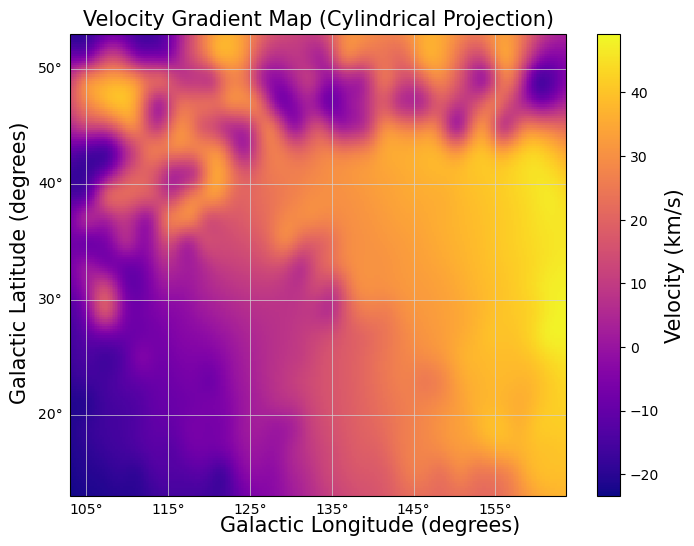

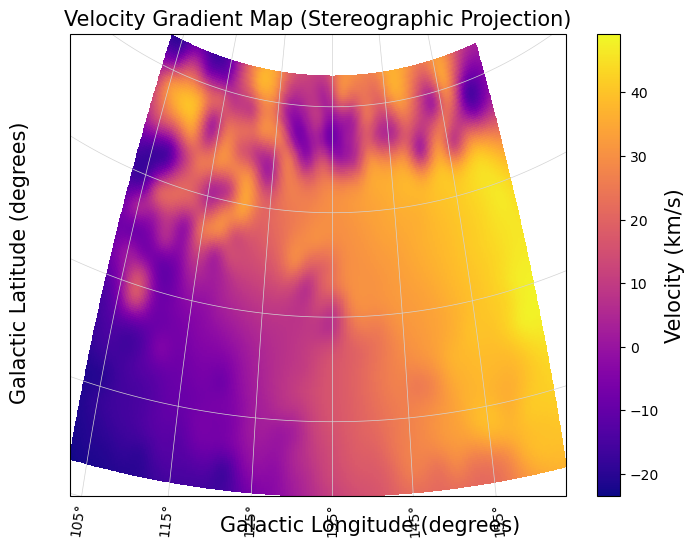

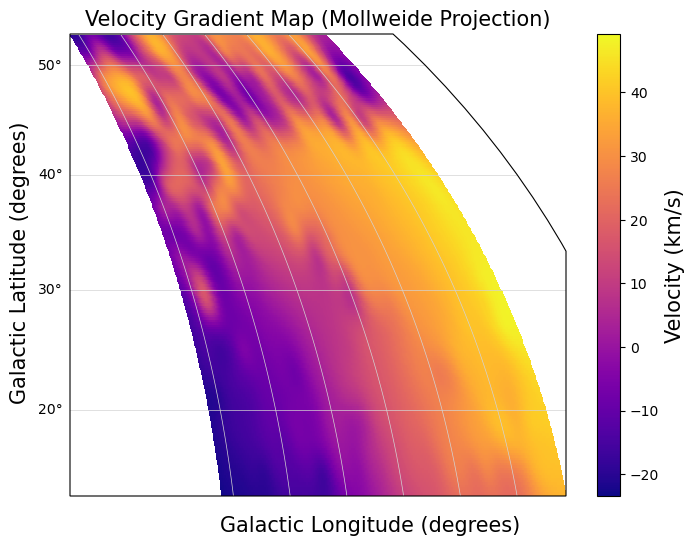

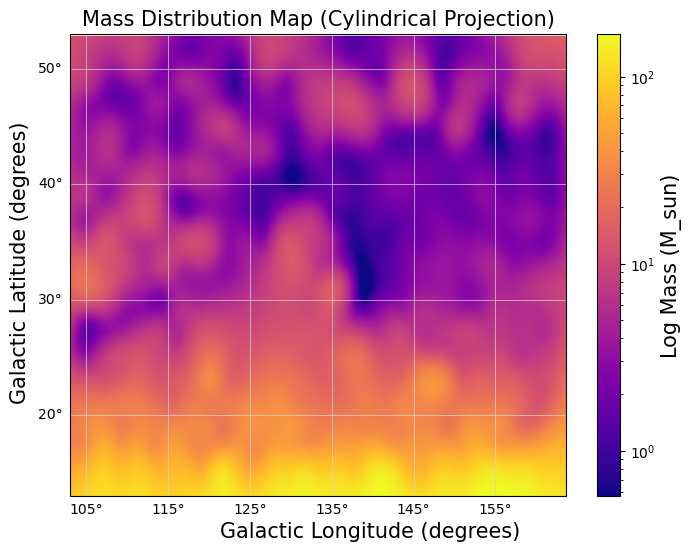

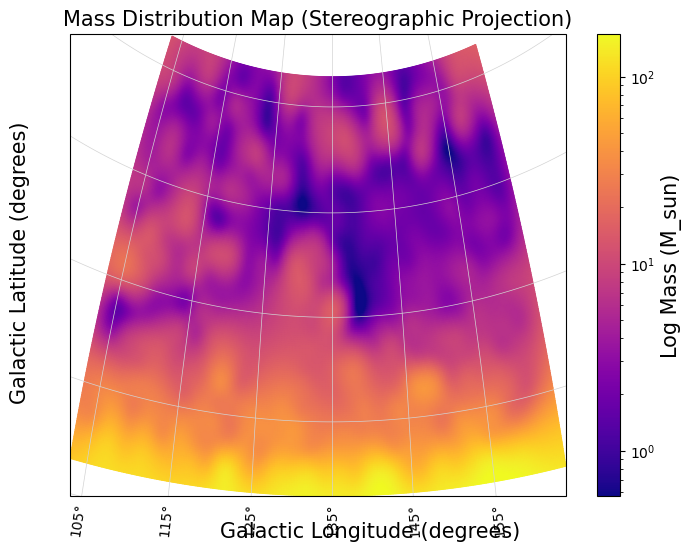

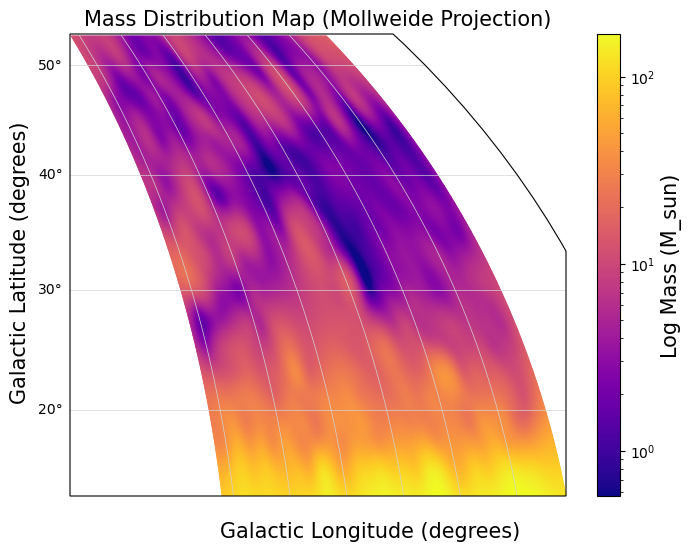

In [ ]:
from scipy.interpolate import Rbf

@dataclass
class MapPoint:
    l: float
    b: float
    v_avg: float
    brightness: float
    mass: float

def mapDataToMapPoint(map_data):
    points = []
    for p in map_data:
        point = MapPoint(
            l=p.l,
            b=p.b,
            v_avg=p.v_avg,
            brightness=p.brightness,
            mass=p.total_mass
        )
        points.append(point)
    return points

def brightness_to_rgb_color(rgb, brightness):
    return tuple(brightness * c for c in rgb)

def plot_cylindrical(points, size=10, xlim=None, ylim=None):
    plt.figure(figsize=graphSizeSingle)

    l_list = [p.l for p in points]
    b_list = [p.b for p in points]
    v_list = [p.v_avg / 1e3 for p in points]
    alpha_list = [p.brightness for p in points]

    cmap = plt.cm.plasma
    v_min = np.percentile(v_list, 5)
    v_max = np.percentile(v_list, 95)
    norm = mpl.colors.Normalize(vmin=v_min, vmax=v_max)
    sc = plt.scatter(l_list, b_list, c=v_list, cmap=cmap, norm=norm, s=size, alpha=alpha_list)
    cbar = plt.colorbar(sc, orientation='vertical')
    cbar.set_label("Velocity (km/s)", fontsize=axisSize)

    plt.title("Cylindrical Equidistant Projection", fontsize=titleSize)
    plt.xlabel("Galactic Longitude (degrees)", fontsize=axisSize)
    plt.ylabel("Galactic Latitude (degrees)", fontsize=axisSize)

    plt.grid(True)
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.show()

def plot_stereographic(points, center_l=135, center_b=32, size=10, xlim=None, ylim=None):
    plt.figure(figsize=graphSizeSingle)

    x_list, y_list = [], []
    v_list = [p.v_avg / 1e3 for p in points]
    alpha_list = [p.brightness for p in points]

    for p in points:
        delta_lon = np.radians(p.l - center_l)
        lat = np.radians(p.b)
        R = np.tan(0.5 * (np.pi/2 - lat))
        x = R * np.sin(delta_lon)
        y = R * np.cos(delta_lon)
        x_list.append(x)
        y_list.append(y)

    cmap = plt.cm.plasma
    v_min = np.percentile(v_list, 5)
    v_max = np.percentile(v_list, 95)
    norm = mpl.colors.Normalize(vmin=v_min, vmax=v_max)

    sc = plt.scatter(x_list, y_list, c=v_list, cmap=cmap, norm=norm, s=size, alpha=alpha_list)
    cbar = plt.colorbar(sc, orientation='vertical')
    cbar.set_label("Velocity (km/s)", fontsize=axisSize)

    plt.title("Stereographic Projection", fontsize=titleSize)
    plt.xlabel("X = R sin(Δlon)", fontsize=axisSize)
    plt.ylabel("Y = R cos(Δlon)", fontsize=axisSize)

    plt.grid(True)
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.show()

def plot_mollweide(points, size=10, xlim=None, ylim=None):
    plt.figure(figsize=graphSizeSingle)
    ax = plt.subplot(111, projection="mollweide")

    lon_list = [np.radians(p.l) for p in points]
    lat_list = [np.radians(p.b) for p in points]
    v_list = [p.v_avg / 1e3 for p in points]
    alpha_list = [p.brightness for p in points]

    cmap = plt.cm.plasma
    v_min = np.percentile(v_list, 5)
    v_max = np.percentile(v_list, 95)
    norm = mpl.colors.Normalize(vmin=v_min, vmax=v_max)

    sc = ax.scatter(lon_list, lat_list, c=v_list, cmap=cmap, norm=norm, s=size, alpha=alpha_list)

    cbar = plt.colorbar(sc, orientation="vertical", pad=0.07)
    cbar.set_label("Velocity (km/s)", fontsize=axisSize)

    ax.set_title("Mollweide Projection", fontsize=titleSize)
    ax.grid(True)

    # Optional axis labels using fig.text
    fig = plt.gcf()
    fig.text(0.5, 0.05, 'Galactic Longitude (radians)', ha='center', fontsize=axisSize)
    fig.text(0.05, 0.5, 'Galactic Latitude (radians)', va='center', rotation='vertical', fontsize=axisSize)

    plt.show()

def plot_cartopy(points, projection='mollweide', size=10, focus_area=False, show_map_background=False, show_grid_labels=True):
    if projection == 'cylindrical':
        proj = ccrs.PlateCarree()
    elif projection == 'stereographic':
        proj = ccrs.Stereographic(central_longitude=135, central_latitude=32)
    elif projection == 'mollweide':
        proj = ccrs.Mollweide(central_longitude=0)
    else:
        raise ValueError("Unknown projection type")

    fig = plt.figure(figsize=graphSizeSingle)
    ax = plt.axes(projection=proj)

    if not focus_area:
        ax.set_global()
    else:
        ax.set_extent([103, 162, 13, 52], crs=ccrs.PlateCarree())

    if show_map_background:
        ax.coastlines(resolution='110m', color='gray', linewidth=0.5)

    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=show_grid_labels, color='lightgray', linewidth=0.5)
    if show_grid_labels:
        gl.top_labels = False
        gl.right_labels = False
        gl.xlabel_style = {'size': 10}
        gl.ylabel_style = {'size': 10}
        gl.xformatter = mpl.ticker.FuncFormatter(lambda x, _: f"{x:.0f}°")
        gl.yformatter = mpl.ticker.FuncFormatter(lambda y, _: f"{y:.0f}°")
        gl.xlocator = mpl.ticker.FixedLocator(np.arange(105, 165, 10))
        gl.ylocator = mpl.ticker.FixedLocator(np.arange(10, 55, 10))

    l_list = [p.l for p in points]
    b_list = [p.b for p in points]
    v_list = [p.v_avg / 1e3 for p in points]
    bright_list = [p.brightness for p in points]
    
    v_min = np.percentile(v_list, 5)
    v_max = np.percentile(v_list, 95)
    b_min, b_max = min(bright_list), max(bright_list)
    alpha_list = [np.clip((b - b_min) / (b_max - b_min), 0, 1) for b in bright_list]

    cmap = plt.cm.plasma
    norm = mpl.colors.Normalize(vmin=v_min, vmax=v_max)

    sc = ax.scatter(
        l_list, b_list, c=v_list, cmap=cmap, norm=norm,
        s=size, alpha=alpha_list, transform=ccrs.PlateCarree()
    )

    cbar = plt.colorbar(sc, ax=ax, orientation="vertical", shrink=0.7, pad=0.05)
    cbar.set_label("Velocity (km/s)", fontsize=axisSize)

    ax.set_title(f"Cartopy Map ({projection.title()} Projection)", fontsize=titleSize)

    # Axis labels
    fig.text(0.5, 0.05, 'Galactic Longitude (degrees)', ha='center', fontsize=axisSize)
    fig.text(0.05, 0.5, 'Galactic Latitude (degrees)', va='center', rotation='vertical', fontsize=axisSize)

    plt.grid()
    plt.show()

from scipy.interpolate import griddata

def plot_cartopy_interpolated(points, projection='mollweide', resolution=0.5, focus_area=True, show_grid_labels=False, show_map_background=False):
    if projection == 'cylindrical':
        proj = ccrs.PlateCarree()
    elif projection == 'stereographic':
        proj = ccrs.Stereographic(central_longitude=135, central_latitude=32)
    elif projection == 'mollweide':
        proj = ccrs.Mollweide(central_longitude=0)
    else:
        raise ValueError("Unknown projection type")

    fig = plt.figure(figsize=graphSizeSingle)
    ax = plt.axes(projection=proj)

    # Extract scattered data
    l_list = [p.l for p in points]
    b_list = [p.b for p in points]
    v_list = [p.v_avg / 1e3 for p in points]

    # Grid extent (based on data bounds)
    l_min, l_max = min(l_list) - 2, max(l_list) + 2
    b_min, b_max = min(b_list) - 2, max(b_list) + 2

    # Define regular grid
    l_grid = np.arange(l_min, l_max, resolution)
    b_grid = np.arange(b_min, b_max, resolution)
    L, B = np.meshgrid(l_grid, b_grid)

    # Interpolate to grid
    rbf = Rbf(l_list, b_list, v_list, function="multiquadric", smooth=0.5, epsilon=1.5)
    V = rbf(L, B)

    # Set extent
    if focus_area:
        ax.set_extent([l_min, l_max, b_min, b_max], crs=ccrs.PlateCarree())
    else:
        ax.set_global()

    # Optional: background and grid
    if show_map_background:
        ax.coastlines(resolution='110m', color='gray', linewidth=0.5)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, color='lightgray', linewidth=0.5)
    if show_grid_labels:
        gl.top_labels = False
        gl.right_labels = False
        gl.bottom_labels = True
        gl.left_labels = True
        gl.xlabel_style = {'size': 10}
        gl.ylabel_style = {'size': 10}
        gl.xformatter = mpl.ticker.FuncFormatter(lambda x, _: f"{x:.0f}°")
        gl.yformatter = mpl.ticker.FuncFormatter(lambda y, _: f"{y:.0f}°")
        gl.xlocator = mpl.ticker.FixedLocator(np.arange(105, 165, 10))
        gl.ylocator = mpl.ticker.FixedLocator(np.arange(10, 55, 10))

    ax.set_xlabel('Galactic Longitude (degrees)', fontsize=axisSize, labelpad=15)
    ax.set_ylabel('Galactic Latitude (degrees)', fontsize=axisSize, labelpad=15)

    # Color settings
    cmap = plt.cm.plasma
    v_min, v_max = min(v_list), max(v_list)
    norm = mpl.colors.Normalize(vmin=v_min, vmax=v_max)

    # Plot interpolated field
    im = ax.pcolormesh(L, B, V, cmap=cmap, norm=norm, shading='auto', transform=ccrs.PlateCarree())
    ax.set_aspect('auto')

    # Colorbar
    cbar = plt.colorbar(im, ax=ax, orientation='vertical', pad=0.05)
    cbar.set_label("Velocity (km/s)", fontsize=axisSize)

    ax.set_title(f"Velocity Gradient Map ({projection.title()} Projection)", fontsize=titleSize)

    # Axis labels
    fig.text(0.5, 0.05, 'Galactic Longitude (degrees)', ha='center', fontsize=axisSize)
    fig.text(0.05, 0.5, 'Galactic Latitude (degrees)', va='center', rotation='vertical', fontsize=axisSize)

    plt.grid()
    plt.show()

def plot_cartopy_interpolated_mass(points, projection='mollweide', resolution=0.5, focus_area=True, show_grid_labels=False, show_map_background=False):
    if projection == 'cylindrical':
        proj = ccrs.PlateCarree()
    elif projection == 'stereographic':
        proj = ccrs.Stereographic(central_longitude=135, central_latitude=32)
    elif projection == 'mollweide':
        proj = ccrs.Mollweide(central_longitude=0)
    else:
        raise ValueError("Unknown projection type")

    fig = plt.figure(figsize=graphSizeSingle)
    ax = plt.axes(projection=proj)

    # Extract scattered data
    l_list = [p.l for p in points]
    b_list = [p.b for p in points]
    v_list = [p.v_avg / 1e3 for p in points]
    m_list = [p.mass for p in points]

    # Grid extent (based on data bounds)
    l_min, l_max = min(l_list) - 2, max(l_list) + 2
    b_min, b_max = min(b_list) - 2, max(b_list) + 2

    # Define regular grid
    l_grid = np.arange(l_min, l_max, resolution)
    b_grid = np.arange(b_min, b_max, resolution)
    L, B = np.meshgrid(l_grid, b_grid)

    # Interpolate to grid
    rbf = Rbf(l_list, b_list, m_list, function="multiquadric", smooth=0.3, epsilon=1.5)
    V = rbf(L, B)
    
    # Set extent
    if focus_area:
        ax.set_extent([l_min, l_max, b_min, b_max], crs=ccrs.PlateCarree())
    else:
        ax.set_global()

    # Optional: background and grid
    if show_map_background:
        ax.coastlines(resolution='110m', color='gray', linewidth=0.5)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, color='lightgray', linewidth=0.5)
    if show_grid_labels:
        gl.top_labels = False
        gl.right_labels = False
        gl.bottom_labels = True
        gl.left_labels = True
        gl.xlabel_style = {'size': 10}
        gl.ylabel_style = {'size': 10}
        gl.xformatter = mpl.ticker.FuncFormatter(lambda x, _: f"{x:.0f}°")
        gl.yformatter = mpl.ticker.FuncFormatter(lambda y, _: f"{y:.0f}°")
        gl.xlocator = mpl.ticker.FixedLocator(np.arange(105, 165, 10))
        gl.ylocator = mpl.ticker.FixedLocator(np.arange(10, 55, 10))

    ax.set_xlabel('Galactic Longitude (degrees)', fontsize=axisSize, labelpad=15)
    ax.set_ylabel('Galactic Latitude (degrees)', fontsize=axisSize, labelpad=15)

    # Color settings
    cmap = plt.cm.plasma
    m_min, m_max = min(m_list), max(m_list)
    norm = mpl.colors.LogNorm(vmin=m_min, vmax=m_max)

    # Plot interpolated field
    im = ax.pcolormesh(L, B, V, cmap=cmap, norm=norm, shading='gouraud', transform=ccrs.PlateCarree())
    ax.set_aspect('auto')

    # Colorbar
    cbar = plt.colorbar(im, ax=ax, orientation='vertical', pad=0.05)
    cbar.set_label("Log Mass (M_sun)", fontsize=axisSize)

    ax.set_title(f"Mass Distribution Map ({projection.title()} Projection)", fontsize=titleSize)

    # Axis labels
    fig.text(0.5, 0.04, 'Galactic Longitude (degrees)', ha='center', fontsize=axisSize)
    fig.text(0.05, 0.5, 'Galactic Latitude (degrees)', va='center', rotation='vertical', fontsize=axisSize)

    plt.grid()
    plt.show()


def plot_all_projections(points, res=0.5, size=10, xlim=None, ylim=None):
    # plot_cylindrical(points, size=size, xlim=xlim, ylim=ylim)
    # plot_stereographic(points, size=size, xlim=xlim, ylim=ylim)
    # plot_mollweide(points, size=size, xlim=xlim, ylim=ylim)

    # plot_cartopy(points, projection='cylindrical', size=size, focus_area=True, show_grid_labels=True)
    # plot_cartopy(points, projection='stereographic', size=size, focus_area=True, show_grid_labels=True)
    # plot_cartopy(points, projection='mollweide', size=size, focus_area=True, show_grid_labels=True)

    plot_cartopy_interpolated(points, projection='cylindrical', resolution=res, focus_area=True, show_grid_labels=True)
    #plot_cartopy_interpolated(points, projection='stereographic', resolution=res, focus_area=True, show_grid_labels=True)
    plot_cartopy_interpolated(points, projection='mollweide', resolution=res, focus_area=True, show_grid_labels=True)
    plot_cartopy_interpolated_mass(points, projection='cylindrical', resolution=res, focus_area=True, show_grid_labels=True)
    #plot_cartopy_interpolated_mass(points, projection='stereographic', resolution=res, focus_area=True, show_grid_labels=True)
    plot_cartopy_interpolated_mass(points, projection='mollweide', resolution=res, focus_area=True, show_grid_labels=True)

map_points = mapDataToMapPoint(map_data)
plot_all_projections(map_points, res=0.2, xlim=(-100, 100), ylim=(-50, 50))
#plot_cartopy_interpolated(map_points, projection='mollweide', focus_area=True, show_grid_labels=True)